# Training face recognition - Football celebrity recognition

In [86]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.feature import hog
import pickle

## Delete duplicates in the images

In [87]:
import hashlib

def average_hash(image, hash_size=8):
    resized_image = cv2.resize(image,(hash_size,hash_size))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    mean = gray_image.mean()
    return ''.join(['1' if pixel>=mean else '0' for pixel in gray_image.flatten()])

def find_duplicates(directory):
    hashes={}
    duplicates = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root,file)
            if filepath.endswith(('.jpg','jpeg','.png')):
                image = cv2.imread(filepath)
                image_hash = average_hash(image)
                if image_hash in hashes:
                    duplicates.append((filepath, hashes[image_hash]))
                else:
                    hashes[image_hash]=filepath
    return duplicates

def remove_duplicates(duplicates):
    for duplicate in duplicates:
        print(f"Removing duplicates: {duplicate[0]}")
        os.remove(duplicate[0])

In [88]:
dirs = [x for x in os.listdir('faces/') if '.' not in x]
for folder in dirs:
    duplicates = find_duplicates(folder)
    if duplicates:
        print(f'Duplicates found in {folder}')
        remove_duplicates(duplicates)
    else:
        print(f'No duplicates found in {folder}')

No duplicates found in Modric
No duplicates found in Ronaldo
No duplicates found in Ibrahimovic
No duplicates found in Benzema
No duplicates found in Neymar
No duplicates found in Haaland
No duplicates found in Mbappe
No duplicates found in Unknown
No duplicates found in Messi


## Load Data from images

In [89]:
img_size = (90,90)
def load_data(directory='faces',img_size=(90,90)):
    ls = os.listdir(directory)
    #players = ['Messi','Ronaldo','Unknown']
    players = [x for x in ls if '.' not in x]
    X = []
    y = []
    for player in players:
        folder_player = directory+'/'+player
        files = os.listdir(folder_player)
        for file in files:
            image_file = folder_player+'/'+file
            image=plt.imread(image_file)
            image=cv2.resize(image,img_size)
            image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            image = cv2.equalizeHist(image)
            X.append(image)
            y.append(player)
    X = np.array(X)
    y = np.array(y)
    return X,y

# Split Data  into Train-Test set:
- Load images data from "faces/"
- Split the data into train, and test (80/20)

In [90]:
X,y = load_data(directory='faces')
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.25,random_state=33)

### Extract HOG Features

In [91]:
def HOG(x):
    parameters = {'pixels_per_cell':(12,12),
                  'cells_per_block':(3,3),
                  'orientations':6,
                  'image_size':img_size}
    with open('hog_parameters.para','wb') as f:
        pickle.dump(parameters,f)
    
    return hog(x,pixels_per_cell=parameters['pixels_per_cell'],
               cells_per_block=parameters['cells_per_block'],
               orientations=parameters['orientations'])

def computeHOG(X):
    if len(X.shape)>=3:
        hog_features = []
        for image in X:
            hog_features.append(HOG(image))
    elif type(X)==list:
        hog_features = []
        for image in X:
            hog_features.append(HOG(image))
    else:
        hog_features = HOG(X)
    return np.array(hog_features)

In [92]:
features_train = computeHOG(X_train)
features_test = computeHOG(X_test)

## Training the Model

In [93]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.svm import SVC

In [94]:
svm = SVC(class_weight='balanced',random_state=33,C=1.0,probability=True)
scaler = make_pipeline(RobustScaler(),MinMaxScaler())
preprocessor = Pipeline(steps=[('scaler1',scaler)],verbose=True)
model = Pipeline(steps = [('preprocessor',preprocessor),('classifier',svm)],verbose=True)

In [95]:
model.fit(features_train,y_train)

[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   0.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   7.7s


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler1',
                                  Pipeline(steps=[('robustscaler',
                                                   RobustScaler()),
                                                  ('minmaxscaler',
                                                   MinMaxScaler())]))],
                          verbose=True)),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=33))],
         verbose=True)

In [96]:
model.score(features_test,y_test)

0.8554913294797688

## Tune model Hyperparamaters



In [97]:
from sklearn.model_selection import GridSearchCV
grid = {'classifier__C':[0.2,1.0,2.0,2.9,3.2]}
gs = GridSearchCV(estimator=model,param_grid=grid,cv=4,n_jobs=-1,verbose=True)
gs.fit(features_train,y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   0.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.8s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   7.8s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler1',
                                                         Pipeline(steps=[('robustscaler',
                                                                          RobustScaler()),
                                                                         ('minmaxscaler',
                                                                          MinMaxScaler())]))],
                                                 verbose=True)),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=33))],
                                verbose=True),
             n_jobs=-1, param_grid={'classifier__C': [0.2, 1.0, 2.0, 2.9, 3.2]},
             verbose=True)

In [98]:
print(f'Best Score: {gs.best_score_}')
print(f'Best Model: {gs.best_params_}')

Best Score: 0.8069498069498069
Best Model: {'classifier__C': 2.0}


In [99]:
best_svm = gs.best_estimator_
best_svm.score(features_test,y_test)

0.8670520231213873

## Evaluate the model with Test Set 
- The Confusion Matrix will show how well the model perform on unseen data
- Summarize the models performance on the test set with different metrics

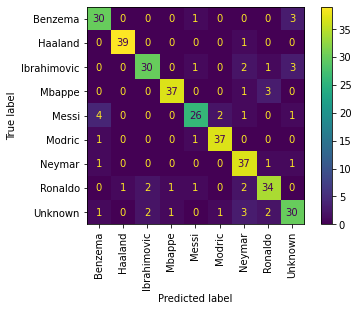

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,best_svm.predict(features_test))
ConfusionMatrixDisplay(cm,display_labels=best_svm.named_steps.classifier.classes_).plot(xticks_rotation=90)

In [101]:
from sklearn.metrics import classification_report
print(classification_report(y_test,best_svm.predict(features_test)))

              precision    recall  f1-score   support

     Benzema       0.81      0.88      0.85        34
     Haaland       0.97      0.97      0.97        40
 Ibrahimovic       0.88      0.81      0.85        37
      Mbappe       0.95      0.90      0.92        41
       Messi       0.87      0.76      0.81        34
      Modric       0.93      0.95      0.94        39
      Neymar       0.79      0.93      0.85        40
     Ronaldo       0.83      0.83      0.83        41
     Unknown       0.79      0.75      0.77        40

    accuracy                           0.87       346
   macro avg       0.87      0.87      0.87       346
weighted avg       0.87      0.87      0.87       346



## Pickle the model

In [102]:
from pickle_ml import save_model, load_model

In [103]:
file_path = 'model.p'
save_model(file_path,best_svm)

[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   0.9s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.9s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  15.0s
[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   1.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  14.1s
[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   1.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.1s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  14.7s
[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   1.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  14.8s
[Pipeline] ........... (step 1 of 1) Processing scaler1, total=   1.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.0s
[Pipel